Simulation d'un ring model grâce au programme brian et observation des conséquences du changement de différents paramêtres

 * simulation d'un ring par l'intermédiaire de brian http://briansimulator.org/
 * courbe de sélectivité en fonction des parametres
 * courbe de sélectivité à différents contrastes

<!-- TEASER_END -->


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
fig_width_pt = 646.79  # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0/72.27               # Convert pt to inches
fig_width = fig_width_pt*inches_per_pt  # width in inches

In [2]:
import brian as sim

/usr/local/lib/python2.7/site-packages/brian/utils/sparse_patch/__init__.py:39: UserWarning: Couldn't find matching sparse matrix patch for scipy version 0.13.3, but in most cases this shouldn't be a problem.
  warnings.warn("Couldn't find matching sparse matrix patch for scipy version %s, but in most cases this shouldn't be a problem." % scipy.__version__)


à voir : http://nbviewer.ipython.org/url/www.yger.net/wp-content/ipynb/topographic.ipynb


## Fonction ring :

In [3]:
def ring(N_theta=360, # nombre de neurones d'entrée = nombre neurones du ring
         tau=10*sim.ms, 
         tau_e=2*sim.ms, 
         sigma_theta_ff=.5, # bandwidth de connections feed-forward
         sigma_theta_lat=.5, # bandwidth de connections latérales
         input_rate=30, # intensité de l'entrée
         input_width=10, # largeur de l'entrée
         weight_ff=1.25, # poids des connections feed-forward
         weight_lat=.1, # poids des connections latérales
         sparseness=.5, 
         t_run=2):
    
    sim.clock.reinit_default_clock()
    rates = sim.zeros(N_theta)*sim.Hz
    rates[N_theta/2-input_width:N_theta/2+input_width] = sim.ones(2*input_width)*input_rate*sim.Hz

    eqs='''
    dv/dt=(I-v)/tau : volt
    dI/dt=-I/tau_e : volt
    '''
    layer0 = sim.PoissonGroup(N_theta, rates=rates)
    layerE = sim.NeuronGroup(N_theta, model=eqs, threshold=10*sim.mV, reset=0*sim.mV)

    topomap = lambda i, j:np.exp((np.cos(2*np.pi*(i-j)/N_theta)-1.)/sigma_theta_ff**2)/sigma_theta_ff*weight_ff*sim.mV
    feedforward = sim.Connection(layer0, layerE, sparseness=sparseness, weight=topomap)

    lateralmap = lambda i, j:np.exp((np.cos(2*np.pi*(i-j)/N_theta)-1.)/sigma_theta_lat**2)/sigma_theta_lat*weight_lat*sim.mV
    WEE = sim.Connection(layerE, layerE, sparseness=sparseness, weight=lateralmap)


    nb_spikes = sim.SpikeCounter(layerE)
    spikes = sim.SpikeMonitor(layerE)
    sim.run(t_run * sim.second)
    spikes_N = []
    for i in range(N_theta) :
        spikes_N.append(nb_spikes[i])

    return spikes, feedforward, WEE, N_theta, spikes_N, rates

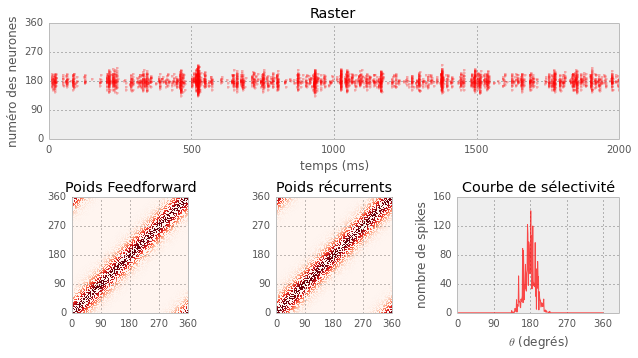

In [4]:
# on lance avec les parametres par défaut
spikes, feedforward, recurrent, N_theta, spikes_N, rates = ring()

fig, ax = sim.subplots(figsize=(fig_width, fig_width*9/16.))
sim.subplot(211)
sim.raster_plot(spikes, color='r', alpha=.3)
sim.yticks(np.linspace(0, 360, 5))
sim.plt.ylabel(u'numéro des neurones')
sim.plt.xlabel(u'temps (ms)')
sim.title('Raster')
sim.ylim([0, 360])
sim.subplot(234)
sim.imshow(feedforward.W.todense(), interpolation='nearest', origin='lower', cmap='Reds')
sim.xticks(np.linspace(0, 360, 5))
sim.yticks(np.linspace(0, 360, 5))
sim.title(u'Poids Feedforward')
sim.subplot(235)
sim.imshow(recurrent.W.todense(), interpolation='nearest', origin='lower', cmap='Reds')
sim.xticks(np.linspace(0, 360, 5))
sim.yticks(np.linspace(0, 360, 5))
sim.title(u'Poids récurrents')
sim.subplot(236)
theta = np.linspace(0, 2*np.pi, N_theta)
sim.plot(theta*180/np.pi, spikes_N, color='r', alpha=.7)
sim.xticks(np.linspace(0, 360, 5))
sim.yticks(np.linspace(0, 160, 5))
sim.plt.xlabel(r'$\theta$ ' u'(degrés)')
sim.plt.ylabel('nombre de spikes')
sim.title(u'Courbe de sélectivité')
sim.plt.tight_layout()
fig.savefig('figures/ring(week2).pdf')

## Variation des paramètres :

### sigma_theta_ff=.5 :

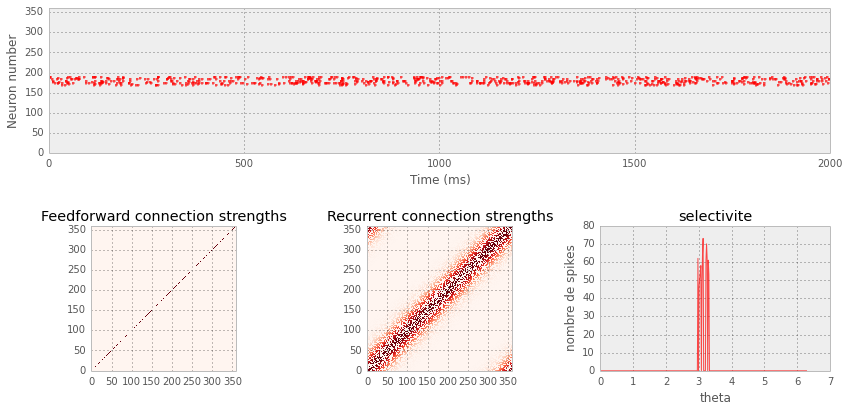

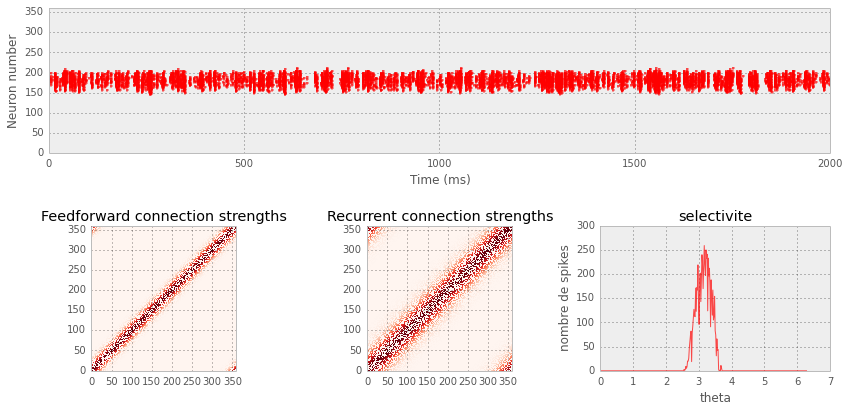

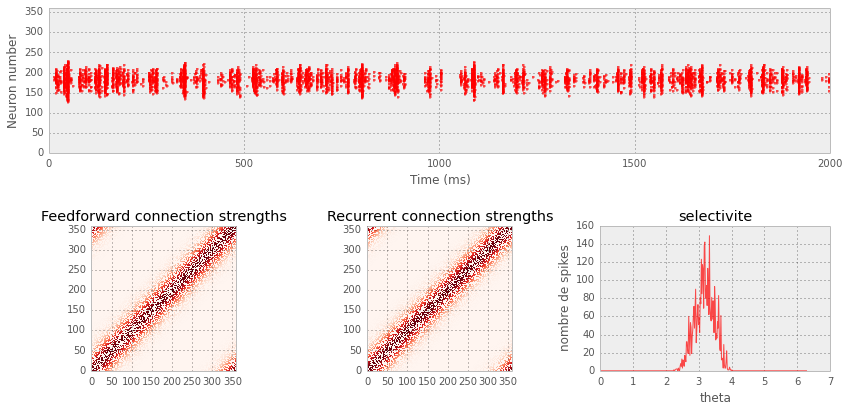

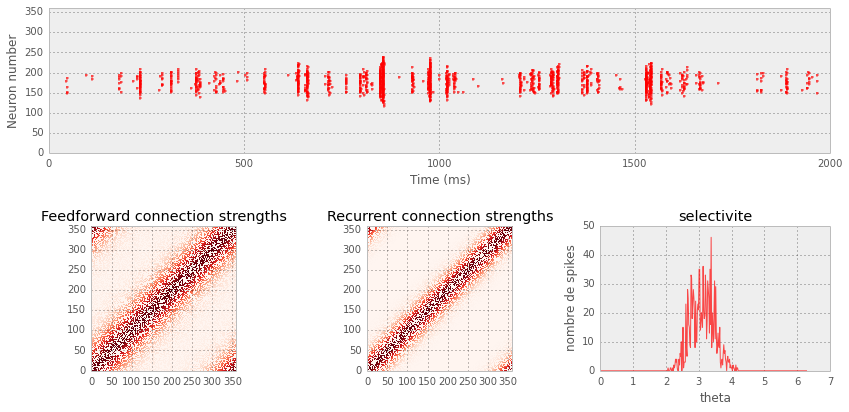

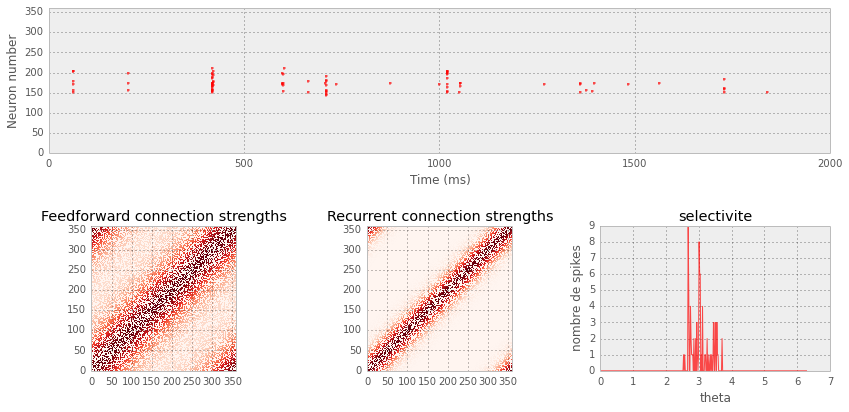

In [5]:
sigma_theta_ff = np.linspace(0.001, 1., 5)

for i, sigma_theta_ff_ in enumerate(sigma_theta_ff) :
    spikes, feedforward, recurrent, N_theta, spikes_N, rates = ring(sigma_theta_ff=sigma_theta_ff_)
    fig, ax = sim.subplots(figsize=(14, 6.5))
    sim.subplot(211)
    sim.raster_plot(spikes, color='r', alpha=.7)
    sim.ylim([0, 360])
    sim.subplot(234)
    sim.imshow(feedforward.W.todense(), interpolation='nearest', origin='lower', cmap='Reds')
    sim.title('Feedforward connection strengths')
    sim.subplot(235)
    sim.imshow(recurrent.W.todense(), interpolation='nearest', origin='lower', cmap='Reds')
    sim.title('Recurrent connection strengths')
    sim.subplot(236)
    theta = np.linspace(0, 2*np.pi, N_theta)
    sim.plot(theta, spikes_N, color='r', alpha=.7)
    sim.plt.xlabel('theta')
    sim.plt.ylabel('nombre de spikes')
    sim.title('selectivite')

* sigma_theta_ff = 0.001 : 
    * connection feedforward pratiquement inexistante, pas de changement dans les connections reccurent
    * pas de décharge neuronal

Quand sigma_theta_ff augmente :

    * connection feedforward augmente
    * la décharge neuronale augmente, puis diminue dépasser une certaine valeur
    * Modifie la courbe de sélectivité

### sigma_theta_lat=.5 :

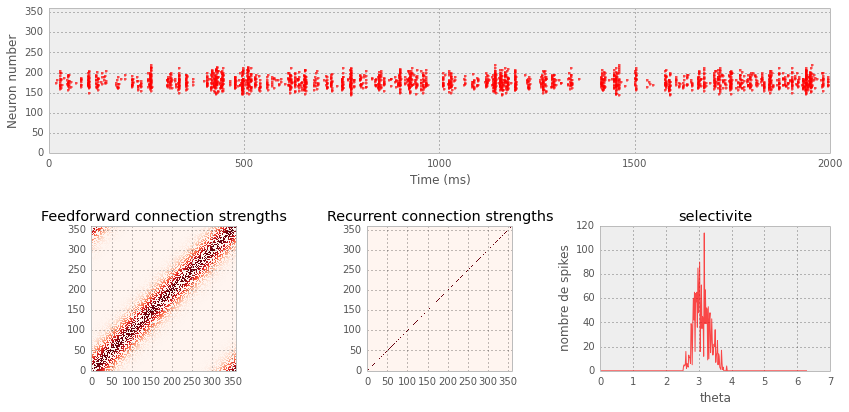

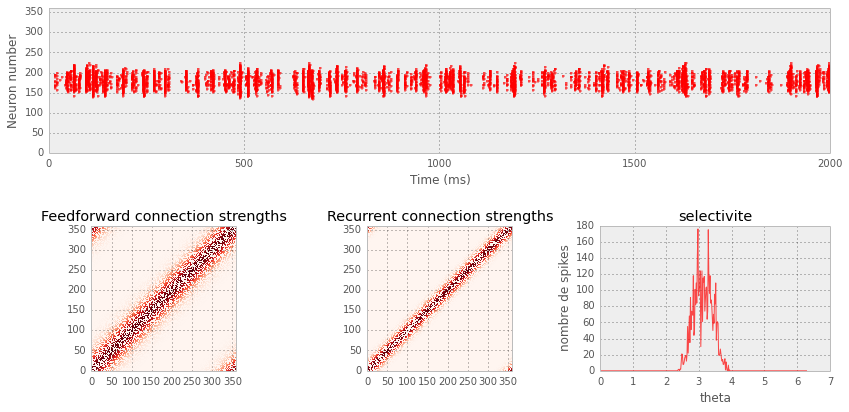

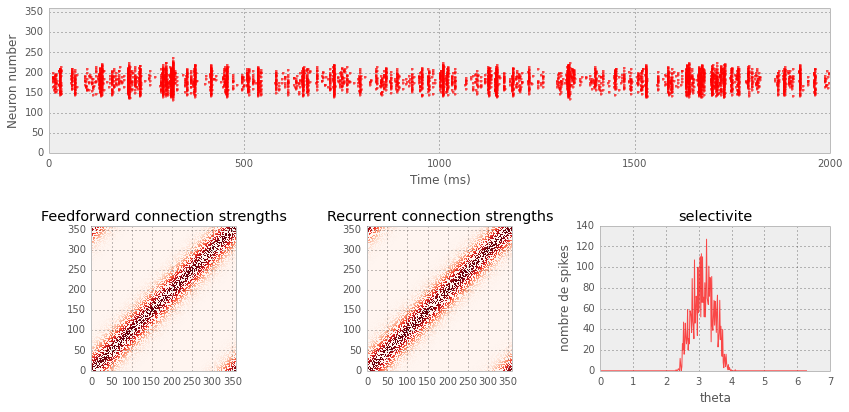

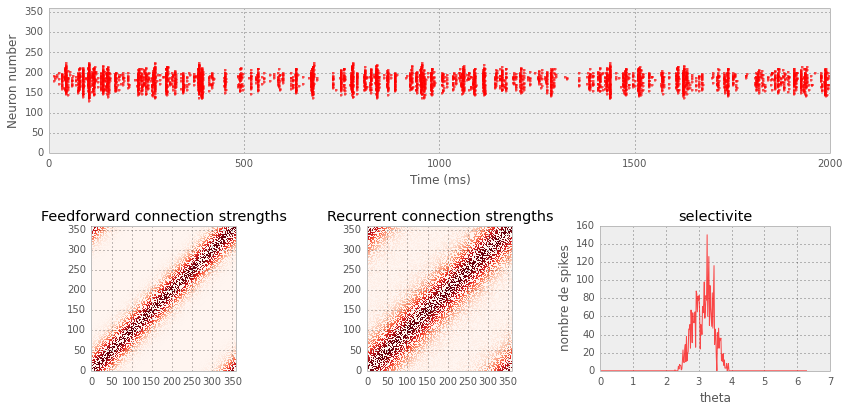

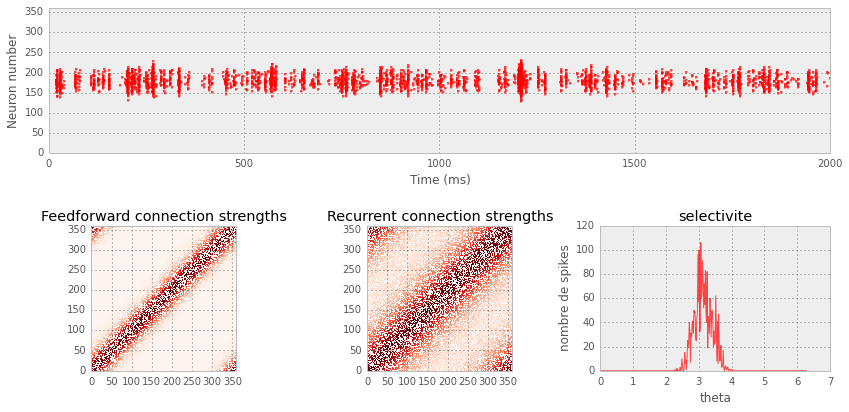

In [6]:
sigma_theta_lat = np.linspace(0.001, 1., 5)

for i, sigma_theta_lat_ in enumerate(sigma_theta_lat): 
    spikes, feedforward, recurrent, N_theta, spikes_N, rates = ring(sigma_theta_lat=sigma_theta_lat_)
    fig, ax = sim.subplots(figsize=(14, 6.5))
    sim.subplot(211)
    sim.raster_plot(spikes, color='r', alpha=.7)
    sim.ylim([0, 360])
    sim.subplot(234)
    sim.imshow(feedforward.W.todense(), interpolation='nearest', origin='lower', cmap='Reds')
    sim.title('Feedforward connection strengths')
    sim.subplot(235)
    sim.imshow(recurrent.W.todense(), interpolation='nearest', origin='lower', cmap='Reds')
    sim.title('Recurrent connection strengths')
    sim.subplot(236)
    theta = np.linspace(0, 2*np.pi, N_theta)
    sim.plot(theta, spikes_N, color='r', alpha=.7)
    sim.plt.xlabel('theta')
    sim.plt.ylabel('nombre de spikes')
    sim.title('selectivite')

* sigma_theta_lat = 0.001 : 
    * connection recurrent pratiquement inexistante, pas de changement dans les connections feedforward
    * décharge neuronal, courbe de selectivité monte jusqu'à 100 spikes et est étroite

quand sigma_theta_lat augmente :
    * connection recurrent augmente
    * décharge neuronale augmente (que l'avant dernier à diminuer)
    * Modifie la courbe de sélectivité

### input_rate=30*sim.Hz :

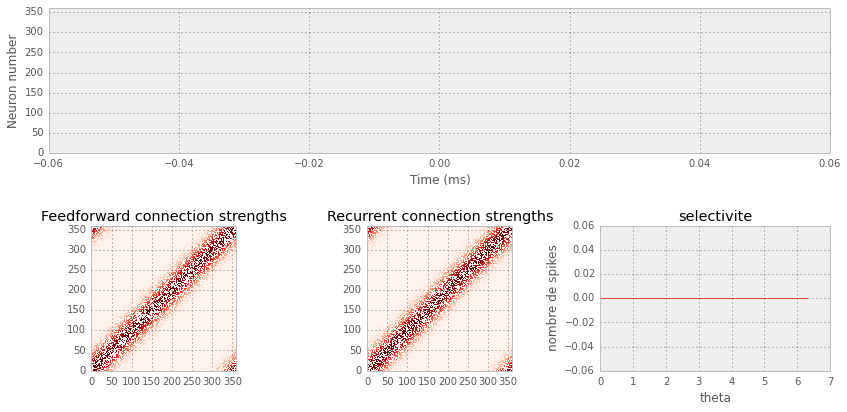

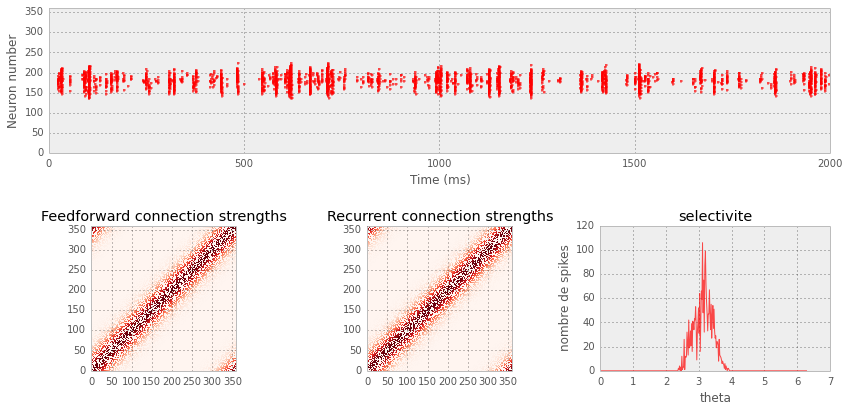

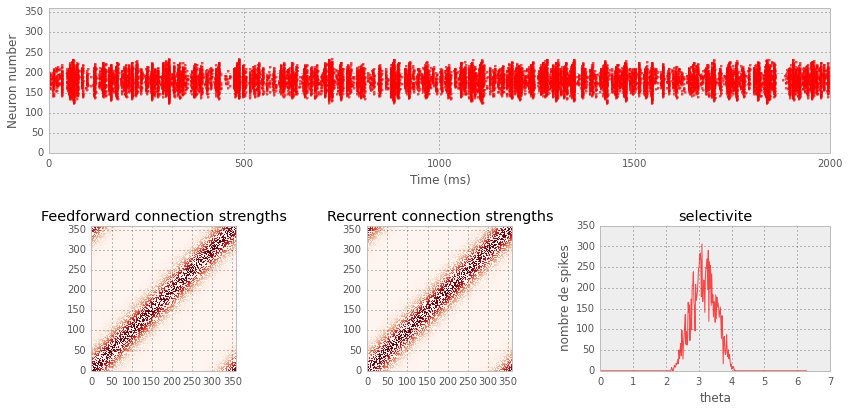

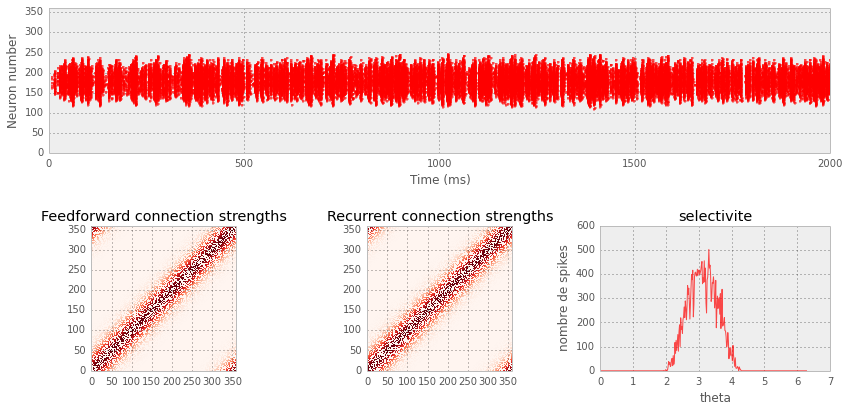

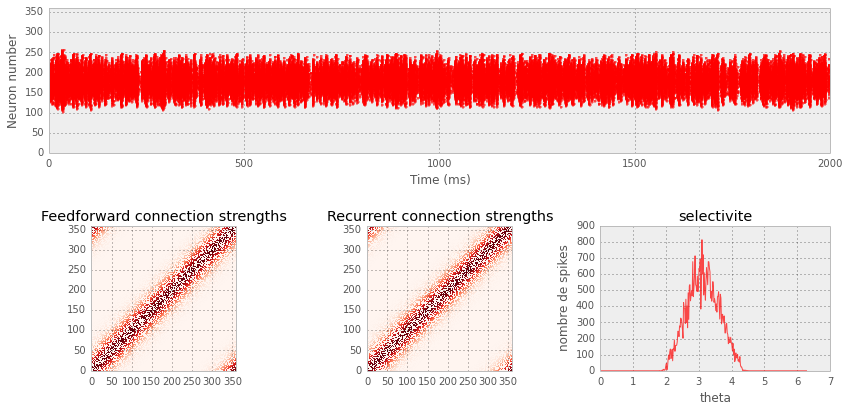

In [7]:
input_rate = np.linspace(0., 100., 5)

for i, input_rate_ in enumerate(input_rate): 
    spikes, feedforward, recurrent, N_theta, spikes_N, rates = ring(input_rate=input_rate_*sim.Hz)
    fig, ax = sim.subplots(figsize=(14, 6.5))
    sim.subplot(211)
    sim.raster_plot(spikes, color='r', alpha=.7)
    sim.ylim([0, 360])
    sim.subplot(234)
    sim.imshow(feedforward.W.todense(), interpolation='nearest', origin='lower', cmap='Reds')
    sim.title('Feedforward connection strengths')
    sim.subplot(235)
    sim.imshow(recurrent.W.todense(), interpolation='nearest', origin='lower', cmap='Reds')
    sim.title('Recurrent connection strengths')
    sim.subplot(236)
    theta = np.linspace(0, 2*np.pi, N_theta)
    sim.plot(theta, spikes_N, color='r', alpha=.7)
    sim.plt.xlabel('theta')
    sim.plt.ylabel('nombre de spikes')
    sim.title('selectivite')

* input_rate = 0*sim.Hz :
    * pas de décharge neuronal, courbe de selectivité plate

Quand input_rate augmente :

    * décharge neuronale augmente
    * Modifie la courbe de sélectivité

-c:16: RuntimeWarning: invalid value encountered in double_scalars


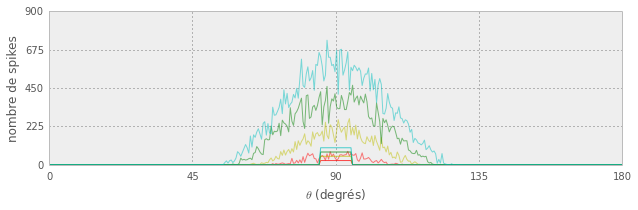

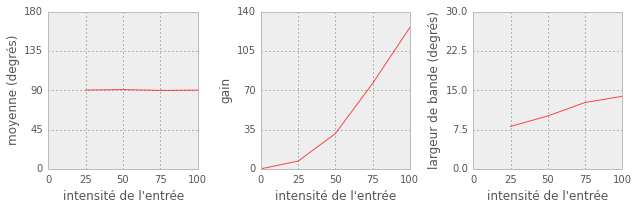

In [8]:
N_theta = 360
N_test = 5
input_rate = np.linspace(0., 100., N_test)
theta = np.linspace(0., np.pi, N_theta)

mean = np.zeros((N_test))
gain_in = np.zeros((N_test))
gain_out = np.zeros((N_test))
bandwidth = np.zeros((N_test))

fig, ax = plt.subplots(figsize=(fig_width, fig_width*6/18.))
for i, (input_rate_ , color) in enumerate(zip(input_rate, ['k', 'r', 'y', 'g', 'c', 'b', 'm', 'k', 'r', 'y',  'g'])): 
    spikes, feedforward, recurrent, N_theta, spikes_N, rates = ring(input_rate=input_rate_)
    gain_in[i] = np.sum(rates)*1./N_theta
    gain_out[i] = np.sum(spikes_N)*1./N_theta
    mean[i] = np.sum(spikes_N*theta)/np.sum(spikes_N)
    bandwidth[i] = np.sqrt(np.sum(spikes_N*(theta-mean[i])**2)/np.sum(spikes_N))
    ax.plot(theta*180/np.pi, spikes_N, color, alpha=0.5)
    ax.plot(theta*180/np.pi, rates, color, alpha=0.7)
ax.set_xticks(np.linspace(0, 180, 5))
ax.set_yticks(np.linspace(0, 900, 5))
ax.set_xlabel(r'$\theta$ ' u'(degrés)')
ax.set_ylabel('nombre de spikes')
#ax.set_title(u'Courbe de sélectivité')
plt.tight_layout()
fig.savefig('figures/selectivite_inputrate(week2).pdf')

fig, ax = plt.subplots(1, 3, figsize=(fig_width, fig_width*6/18.))
ax[0].plot(input_rate, mean*180/np.pi, 'r', alpha=0.7)
#ax[0].plot(input_rate, (np.pi/2)*np.ones(N_test)*180/np.pi, 'k--', alpha=0.7)
ax[0].set_ylim([0, 180])
ax[0].set_xticks(np.linspace(0, 100, 5))
ax[0].set_yticks(np.linspace(0., 180., 5))
#ax[1].plot(input_rate, gain_in*180/np.pi, 'k--', alpha=0.7)
ax[1].plot(input_rate, gain_out, 'r', alpha=0.7)
#ax[1].set_ylim([0, 160.])
ax[1].set_xticks(np.linspace(0, 100, 5))
ax[1].set_yticks(np.linspace(0, 140, 5))
ax[2].plot(input_rate, bandwidth*180/np.pi, 'r', alpha=0.7)
#ax[2].plot(input_rate, sigma_gabor*np.ones(N_test), 'k--', alpha=0.5)
#ax[2].set_ylim([0, 30])
ax[2].set_xticks(np.linspace(0, 100, 5))
ax[2].set_yticks(np.linspace(0, 30, 5))

ax[0].set_xlabel(u"intensité de l'entrée")
ax[0].set_ylabel(u'moyenne (degrés)')

ax[1].set_xlabel(u"intensité de l'entrée")
ax[1].set_ylabel(r'gain')

ax[2].set_xlabel(u"intensité de l'entrée")
_ = ax[2].set_ylabel(u'largeur de bande (degrés)')
plt.tight_layout()
fig.savefig('figures/mean_gain_bandwith_inputrate(week2).pdf')

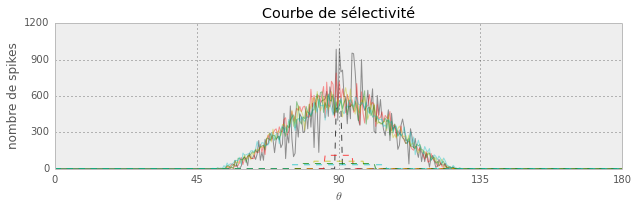

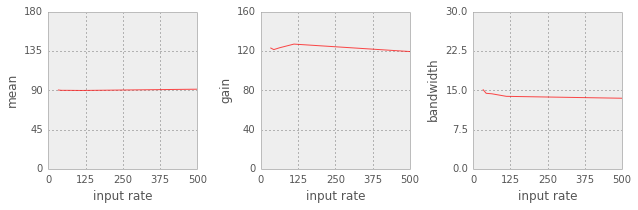

In [9]:
N_theta = 360
N_test = 5
input_rate = 1000/np.linspace(2., 30., N_test)
input_width = np.linspace(2., 30., N_test)
theta = np.linspace(0., np.pi, N_theta)
mean = np.zeros((N_test))
bandwidth = np.zeros((N_test))

fig, ax = plt.subplots(figsize=(fig_width, fig_width*6/18.))
for i, (input_rate_ ,input_width_, color) in enumerate(zip(input_rate,input_width, ['k', 'r', 'y', 'g', 'c', 'b', 'm', 'k', 'r', 'y',  'g'])): 
    spikes, feedforward, recurrent, N_theta, spikes_N, rates = ring(input_rate=input_rate_, input_width=input_width_)
    gain_in[i] = np.sum(rates)*1./N_theta
    gain_out[i] = np.sum(spikes_N)*1./N_theta
    mean[i] = np.sum(spikes_N*(theta))/np.sum(spikes_N)
    bandwidth[i] = np.sqrt(np.sum(spikes_N*((theta)-mean[i])**2)/np.sum(spikes_N))
    ax.plot(theta*180/np.pi, spikes_N, color, alpha=0.4)
    ax.plot(theta*180/np.pi, rates, color, ls='--', alpha=0.7)
ax.set_xticks(np.linspace(0, 180, 5))
ax.set_yticks(np.linspace(0, 1200, 5))
ax.set_xlabel(r'$\theta$')
ax.set_ylabel(r'nombre de spikes')
ax.set_title(u'Courbe de sélectivité')
plt.tight_layout()

fig, ax = plt.subplots(1, 3, figsize=(fig_width, fig_width*6/18.))
ax[0].plot(input_rate, mean*180/np.pi, 'r', alpha=0.7)
ax[0].set_ylim([0., 180.])
ax[0].set_xticks(np.linspace(0, 500, 5))
ax[0].set_yticks(np.linspace(0., 180., 5))
ax[1].plot(input_rate, gain_out, 'r', alpha=0.7)
ax[1].set_ylim([0, 160.])
ax[1].set_xticks(np.linspace(0, 500, 5))
ax[1].set_yticks(np.linspace(0, 160, 5))
ax[2].plot(input_rate, bandwidth*180/np.pi, 'r', alpha=0.7)
ax[2].set_ylim([0, 30])
ax[2].set_xticks(np.linspace(0, 500, 5))
ax[2].set_yticks(np.linspace(0, 30, 5))

ax[0].set_xlabel(r'input rate')
ax[0].set_ylabel(r'mean')

ax[1].set_xlabel(r'input rate')
ax[1].set_ylabel(r'gain')

ax[2].set_xlabel(r'input rate')
_ = ax[2].set_ylabel(r'bandwidth')
plt.tight_layout()


### # FIGURE    input_width=10 :

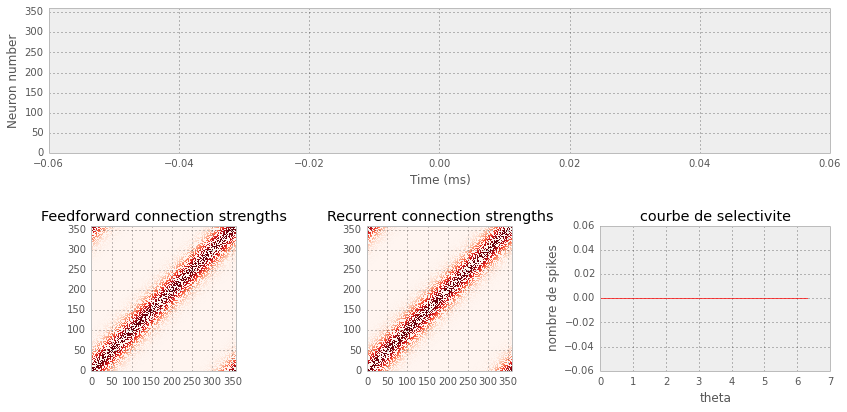

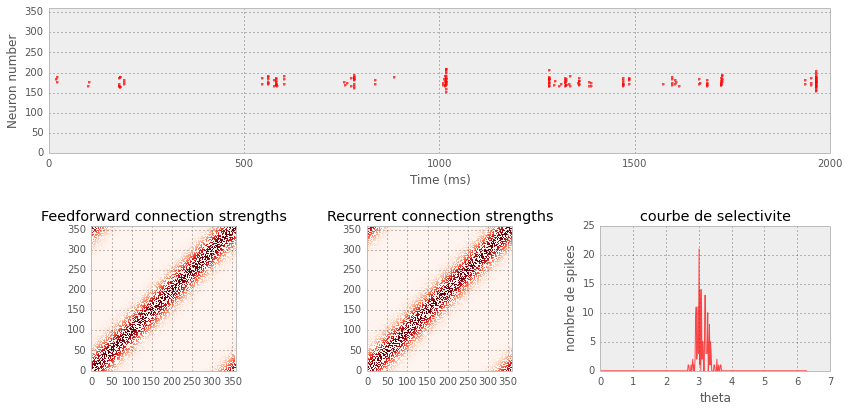

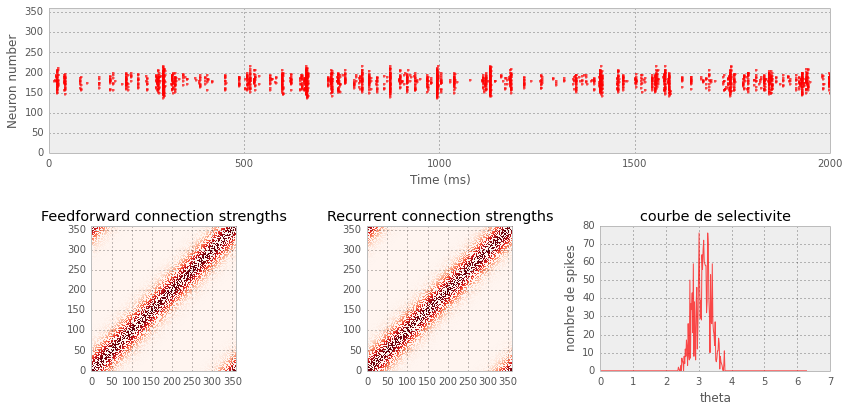

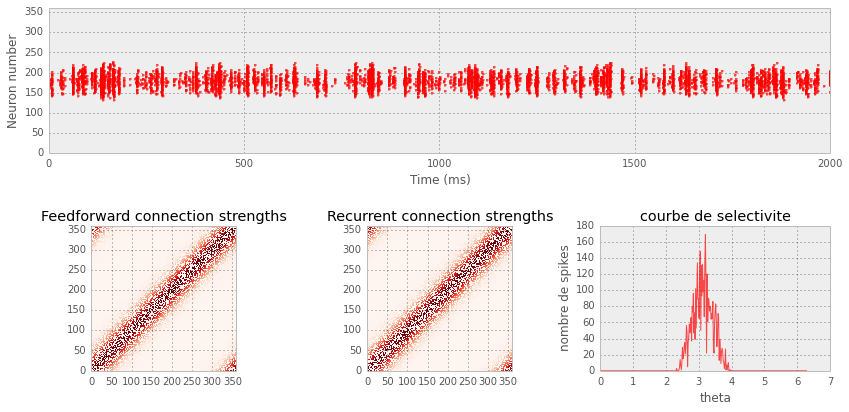

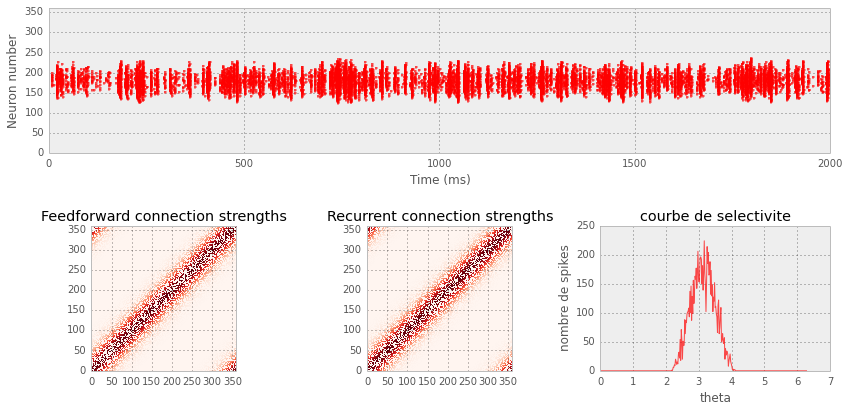

In [10]:
input_width = np.linspace(1., 15., 5)

for i, input_width_ in enumerate(input_width): 
    spikes, feedforward, recurrent, N_theta, spikes_N, rates = ring(input_width=input_width_)
    fig, ax = sim.subplots(figsize=(14, 6.5))
    sim.subplot(211)
    sim.raster_plot(spikes, color='r', alpha=.7)
    sim.ylim([0, 360])
    sim.subplot(234)
    sim.imshow(feedforward.W.todense(), interpolation='nearest', origin='lower', cmap='Reds')
    sim.title('Feedforward connection strengths')
    sim.subplot(235)
    sim.imshow(recurrent.W.todense(), interpolation='nearest', origin='lower', cmap='Reds')
    sim.title('Recurrent connection strengths')
    sim.subplot(236)
    theta = np.linspace(0, 2*np.pi, N_theta)
    sim.plot(theta, spikes_N, color='r', alpha=.7)
    sim.plt.xlabel('theta')
    sim.plt.ylabel('nombre de spikes')
    sim.title('courbe de selectivite')

-c:12: RuntimeWarning: invalid value encountered in double_scalars


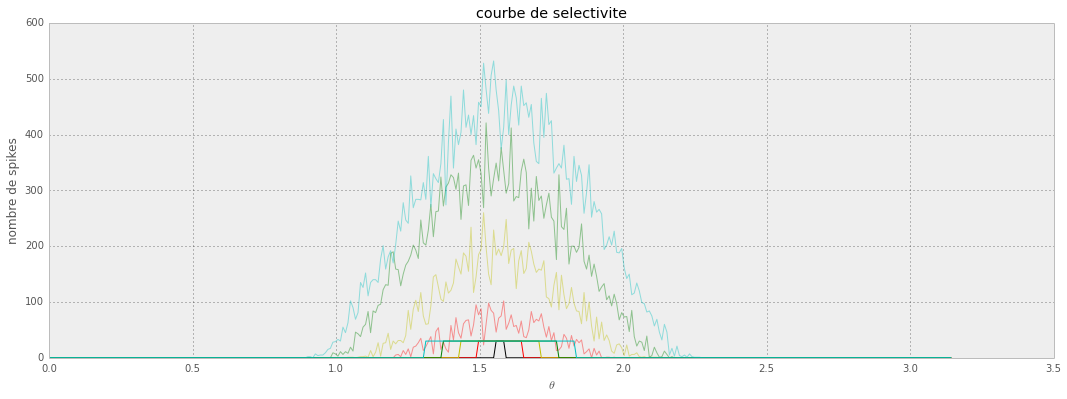

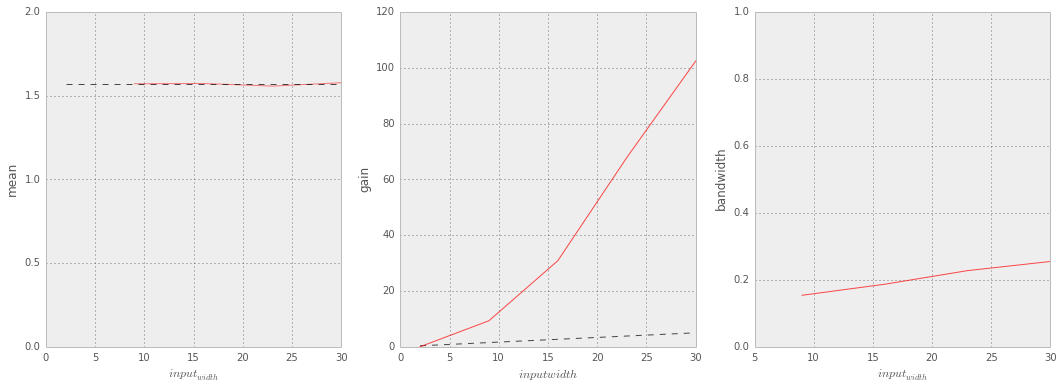

In [11]:
N_test = 5
input_width = np.linspace(2., 30., N_test)
theta = np.linspace(0., np.pi, N_theta)
mean = np.zeros((N_test))
bandwidth = np.zeros((N_test))

fig, ax = plt.subplots(figsize=(18, 6))
for i, (input_width_ , color) in enumerate(zip(input_width, ['k', 'r', 'y', 'g', 'c', 'b', 'm', 'k', 'r', 'y',  'g'])): 
    spikes, feedforward, recurrent, N_theta, spikes_N, rates = ring(input_width=input_width_)
    gain_in[i] = np.sum(rates)*1./N_theta
    gain_out[i] = np.sum(spikes_N)*1./N_theta
    mean[i] = np.sum(spikes_N*theta)/np.sum(spikes_N)
    bandwidth[i] = np.sqrt(np.sum(spikes_N*(theta-mean[i])**2)/np.sum(spikes_N))
    ax.plot(theta, spikes_N, color, alpha=0.4)
    ax.plot(theta, rates, color)
ax.set_xlabel(r'$\theta$')
ax.set_ylabel('nombre de spikes')
ax.set_title('courbe de selectivite')

fig, ax = plt.subplots(1, 3, figsize=(18, 6))
ax[0].plot(input_width, mean, 'r', alpha=0.5)
ax[0].plot(input_width, (np.pi/2)*np.ones(N_test), 'k--', alpha=0.7)
ax[0].set_ylim([0, 2.])
ax[1].plot(input_width, gain_in, 'k--', alpha=0.7)
ax[1].plot(input_width, gain_out, 'r', alpha=0.7)
ax[2].plot(input_width, bandwidth, 'r', alpha=0.7)
ax[2].set_ylim([0, 1.])

ax[0].set_xlabel(r'$input_{width}$')
ax[0].set_ylabel(r'mean')

ax[1].set_xlabel(r'$input {width}$')
ax[1].set_ylabel(r'gain')

ax[2].set_xlabel(r'$input_{width}$')
_ = ax[2].set_ylabel(r'bandwidth')

* input_width = 0*sim.Hz : 
    * connections feedforward et connections recurrent inchangées
    * pas de décharge neuronal, courbe de selectivité plate
* input_width = 2 : décharge neuronale très faible, courbe de selectivite monte juska 3 spikes
* input_width = 13 : profil d'activité large (ne commence pas à 0 mais a 45spikes, augmente jusqu'à 300)
* input_width = disparition de la courbe de selectivité

quand input_width augmente :

    * décharge neuronale augmente
    * Modifie la courbe de sélectivité

### weight_ff=1.25 :

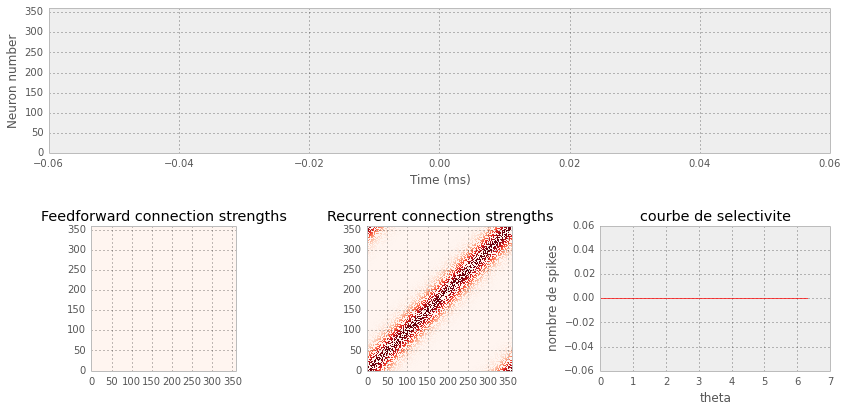

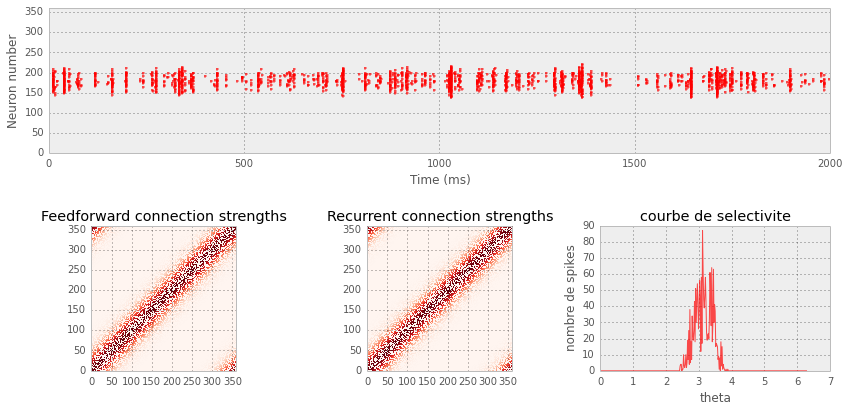

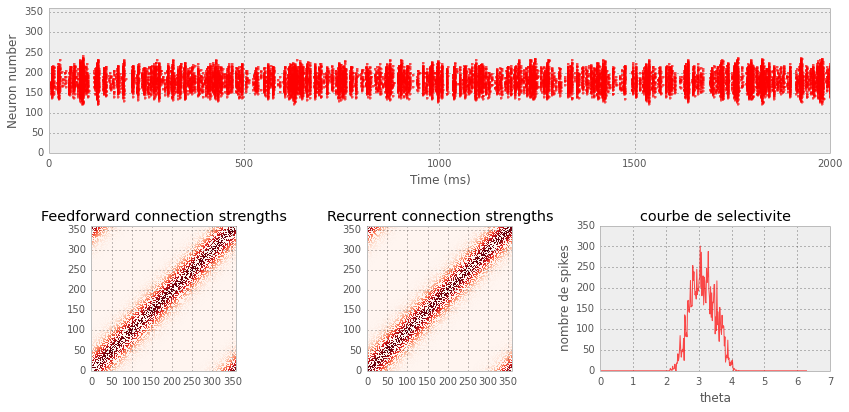

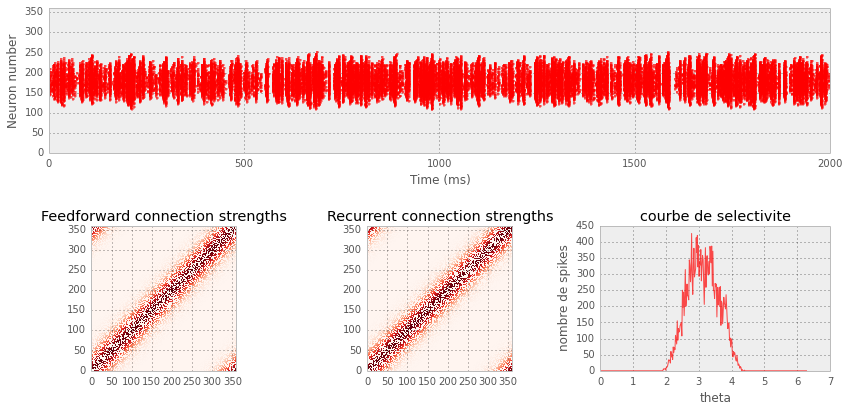

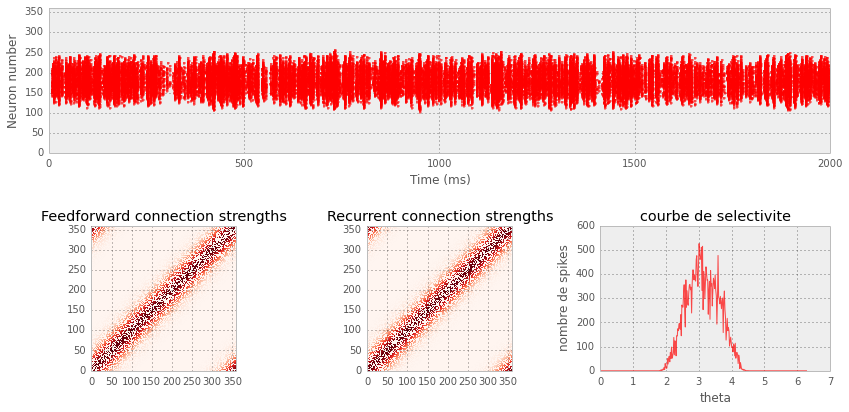

In [ ]:
weight_ff = np.linspace(0., 4., 5)

for i, weight_ff_ in enumerate(weight_ff): 
    spikes, feedforward, recurrent, N_theta, spikes_N, rates = ring(weight_ff=weight_ff_)
    fig, ax = sim.subplots(figsize=(14, 6.5))
    sim.subplot(211)
    sim.raster_plot(spikes, color='r', alpha=.7)
    sim.ylim([0, 360])
    sim.subplot(234)
    sim.imshow(feedforward.W.todense(), interpolation='nearest', origin='lower', cmap='Reds')
    sim.title('Feedforward connection strengths')
    sim.subplot(235)
    sim.imshow(recurrent.W.todense(), interpolation='nearest', origin='lower', cmap='Reds')
    sim.title('Recurrent connection strengths')
    sim.subplot(236)
    theta = np.linspace(0, 2*np.pi, N_theta)
    sim.plot(theta, spikes_N, color='r', alpha=.7)
    sim.plt.xlabel('theta')
    sim.plt.ylabel('nombre de spikes')
    sim.title('courbe de selectivite')

* weight_ff = 0*sim.Hz : 
    * pas de connections feedforward, connections recurrent inchangées
    * pas de décharge neuronal, courbe de selectivité plate
* weight_ff = 1.5 : décharge neuronale très faible, courbe de selectivite monte juska 20 spikes
* weight_ff = 3.1 : profil d'activité large

quand weight_ff augmente :

    * décharge neuronale augmente
    * augmente les connections feedforward
    * Modifie la courbe de sélectivité

### weight_lat=.1 :

In [ ]:
weight_lat = np.linspace(0., .25, 5)

for i, weight_lat_ in enumerate(weight_lat): 
    spikes, feedforward, recurrent, N_theta, spikes_N, rates = ring(weight_lat=weight_lat_)
    fig, ax = sim.subplots(figsize=(14, 6.5))
    sim.subplot(211)
    sim.raster_plot(spikes, color='r', alpha=.7)
    sim.ylim([0, 360])
    sim.subplot(234)
    sim.imshow(feedforward.W.todense(), interpolation='nearest', origin='lower', cmap='Reds')
    sim.title('Feedforward connection strengths')
    sim.subplot(235)
    sim.imshow(recurrent.W.todense(), interpolation='nearest', origin='lower', cmap='Reds')
    sim.title('Recurrent connection strengths')
    sim.subplot(236)
    theta = np.linspace(0, 2*np.pi, N_theta)
    sim.plot(theta, spikes_N, color='r', alpha=.7)
    sim.plt.xlabel('theta')
    sim.plt.ylabel('nombre de spikes')
    sim.title('courbe de selectivite')

* weight_lat = 0*sim.Hz : 
    * pas de connections recurrent, connections feedforward inchangées
    * décharge neuronal, courbe de selectivité monte jusqu'à 120 spikes
* weight_lat = 0.22 : profil d'activité large (mais atypique)

quand weight_ff augmente :
    * décharge neuronale augmente
    * Modifie la courbe de sélectivité



## OBSOLETE: essai avec COBA - balanced

In [ ]:
def ring(N_theta=360, 
         tau=10*sim.ms,
         tau_e=2*sim.ms,
         sigma_theta_ff=.5, 
         sigma_theta_lat=.5, 
         sigma_theta_lat_I=.5, 
         input_rate=30*sim.Hz, 
         input_width=10,
         weight_ff=1.25, 
         weight_lat=.1, 
         w_e=2.5, w_i=-.2, 
         sparseness=0.2, 
         balanced=False, 
         t_run=2):
    
    sim.clock.reinit_default_clock()
    rates = sim.zeros(N_theta)*sim.Hz
    rates[N_theta/2-input_width:N_theta/2+input_width] = sim.ones(2*input_width)*input_rate

    if balanced: 
        eqs='''
        dv/dt = (ge+gi-(v+49*mV))/(20*ms) : volt
        dge/dt = -ge/(5*ms) : volt
        dgi/dt = -gi/(10*ms) : volt
        '''
        layer0 = sim.PoissonGroup(N_theta, rates=rates)
        layerE = sim.NeuronGroup(N_theta, model=eqs, threshold=10*sim.mV, reset=0*sim.mV)
        layerI = sim.NeuronGroup(N_theta, model=eqs, threshold=10*sim.mV, reset=0*sim.mV)

        topomap = lambda i, j:np.exp((np.cos(2*np.pi*(i-j)/N_theta)-1.)/sigma_theta_ff**2)/sigma_theta_ff*weight_ff*sim.mV
        feedforward = sim.Connection(layer0, layerE, sparseness=sparseness, weight=topomap)

        lateralmap_E = lambda i, j:np.exp((np.cos(2*np.pi*(i-j)/N_theta)-1.)/sigma_theta_lat**2)/sigma_theta_lat*w_e*sim.mV
        lateralmap_I = lambda i, j:np.exp((np.cos(2*np.pi*(i-j)/N_theta)-1.)/sigma_theta_lat_I**2)/sigma_theta_lat_I*w_i*sim.mV

        WEE = sim.Connection(layerE, layerE, 'ge', sparseness=sparseness, weight=lateralmap_E)
        WEI = sim.Connection(layerE, layerI, 'ge', sparseness=sparseness, weight=lateralmap_E)
        WII = sim.Connection(layerI, layerI, 'gi', sparseness=sparseness, weight=lateralmap_I)
        WIE = sim.Connection(layerI, layerE, 'gi', sparseness=sparseness, weight=lateralmap_I)

    else:
        eqs='''
        dv/dt=(I-v)/tau : volt
        dI/dt=-I/tau_e : volt
        '''
        layer0 = sim.PoissonGroup(N_theta, rates=rates)
        layerE = sim.NeuronGroup(N_theta, model=eqs, threshold=10*sim.mV, reset=0*sim.mV)

        topomap = lambda i, j:np.exp((np.cos(2*np.pi*(i-j)/N_theta)-1.)/sigma_theta_ff**2)/sigma_theta_ff*weight_ff*sim.mV
        feedforward = sim.Connection(layer0, layerE, sparseness=.5, weight=topomap)

        lateralmap = lambda i, j:np.exp((np.cos(2*np.pi*(i-j)/N_theta)-1.)/sigma_theta_lat**2)/sigma_theta_lat*weight_lat*sim.mV
        WEE = sim.Connection(layerE, layerE, sparseness=.5, weight=lateralmap)


    nb_spikes = sim.SpikeCounter(layerE)
    spikes = sim.SpikeMonitor(layerE)
    sim.run(t_run * sim.second)
    spikes_N = []
    for i in range(N_theta) :
        spikes_N.append(nb_spikes[i])

    return spikes, feedforward, WEE, N_theta, spikes_N, rates
# on lance avec les parametres par défaut
spikes, feedforward, recurrent, N_theta, spikes_N, rates = ring()

sim.clock.reinit_default_clock()
t_run = 2

N_theta=360
sigma_theta_ff, sigma_theta_lat_E, sigma_theta_lat_I = .8, .5, .5
w_e, w_i = 1.2, -1.8
eqs='''
dv/dt = (ge+gi-(v+49*mV))/(20*ms) : volt
dge/dt = -ge/(5*ms) : volt
dgi/dt = -gi/(10*ms) : volt
'''


rates = sim.zeros(N_theta)*sim.Hz
rates[N_theta/2-10:N_theta/2+10] = sim.ones(20)*30*sim.Hz
layer0 = sim.PoissonGroup(N_theta, rates=rates)
layerE = sim.NeuronGroup(N_theta, model=eqs, threshold=10*sim.mV, reset=0*sim.mV)
layerI = sim.NeuronGroup(N_theta, model=eqs, threshold=10*sim.mV, reset=0*sim.mV)

topomap = lambda i, j:np.exp((np.cos(2*np.pi*(i-j)/N_theta)-1.)/sigma_theta_ff**2)*2.5*sim.mV
feedforward = sim.Connection(layer1, layerE, sparseness=.5, weight=topomap)

#lateralmap = lambda i, j:sim.exp(-np.abs(np.mod(i-j+N_theta/2, N_theta)-N_theta/2)/sigma_theta_lat)*0.5*sim.mV
lateralmap_E = lambda i, j:np.exp((np.cos(2*np.pi*(i-j)/N_theta)-1.)/sigma_theta_lat_E**2)*w_e*sim.mV
lateralmap_I = lambda i, j:np.exp((np.cos(2*np.pi*(i-j)/N_theta)-1.)/sigma_theta_lat_I**2)*w_i*sim.mV

WEE = sim.Connection(layerE, layerE, 'ge', sparseness=0.02, weight=lateralmap_E)
WEI = sim.Connection(layerE, layerI, 'ge', sparseness=0.02, weight=lateralmap_E)
WII = sim.Connection(layerI, layerI, 'gi', sparseness=0.02, weight=lateralmap_I)
WIE = sim.Connection(layerI, layerE, 'gi', sparseness=0.02, weight=lateralmap_I)


nb_spikes = sim.SpikeCounter(layerE)
spikes = sim.SpikeMonitor(layerE)
sim.run(t_run * sim.second)
spikes_N = []
for i in range(N_theta) :
    spikes_N.append(nb_spikes[i])

fig, ax = sim.subplots(figsize=(14, 9))
sim.subplot(211)
sim.raster_plot(spikes)
sim.ylim([0, 360])
sim.subplot(234)
sim.imshow(WEE.W.todense(), interpolation='nearest', origin='lower')
sim.title('Feedforward connection strengths')
sim.subplot(235)
sim.imshow(WII.W.todense(), interpolation='nearest', origin='lower')
sim.title('Recurrent connection strengths')
sim.subplot(236)
theta = np.linspace(0, 2*np.pi, N_theta)
sim.plot(theta, spikes_N)
sim.plt.xlabel('theta')
sim.plt.ylabel('nombre de spikes')
sim.title('courbe de selectivite')
sim.title('theta')

In [ ]:
w_i = np.linspace(-.3, 0., 5)

for i, w_i_ in enumerate(w_i): 
    spikes, feedforward, recurrent, N_theta, spikes_N, rates = ring(w_i=w_i_, balanced=True)
    fig, ax = sim.subplots(figsize=(14, 6.5))
    sim.subplot(211)
    sim.raster_plot(spikes)
    sim.subplot(234)
    sim.imshow(feedforward.W.todense(), interpolation='nearest', origin='lower')
    sim.title('Feedforward connection strengths')
    sim.subplot(235)
    sim.imshow(recurrent.W.todense(), interpolation='nearest', origin='lower')
    sim.title('Recurrent connection strengths')
    sim.subplot(236)
    theta = np.linspace(0, 2*np.pi, N_theta)
    sim.plot(theta, spikes_N)
    sim.plt.xlabel('theta')
    sim.plt.ylabel('nombre de spikes')
    sim.title('selectivite')